# Introduction to Transformers

In [1]:
! pip install nnsight

  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached triton-2.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
Using cached triton-2.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (168.1 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.18.1
    Uninstalling nvidia-nccl-cu12-2.18.1:
      Successfully uninstalled nvidia-nccl-cu12-2.18.1
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninsta

## Table of Contents

**1 - Introduction to NNsight**

We'll start the day by learning the basic syntax of the NNsight and PyTorch libraries.

NNsight is a library for editing and intervening on model internals. PyTorch, a popular library for building deep learning models, enables this with a functionality called hooks. At the output and input of every component in a PyTorch model, hooks enable users to access and set activations.

Specifically, we'll demonstrate NNsight syntax on a simple, two layer neural network. Then, we'll review some concepts in previous weeks and ground our understanding by playing around with a real model using NNsight.

**2 - Logit Lens: A Prelude to Transformers**

To build an intuition for how transformers work, we'll start with a pretty basic experiment using NNsight. The "logit lens" transforms the residual stream of a transformer into token space, allowing us to observe how the probability on certain tokens changes throughout a model. You can read more about the logit lens [here](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens).

If that sentence was a little jargon-y, don't worry. This section will start with a primer on the Transformer architecture and tokenization.

# 1 - Introduction to NNsight

To demonstrate the core functionality and syntax of nnsight, we’ll define and use a tiny two layer neural network.

In [2]:
from collections import OrderedDict
import torch

input_size = 5
hidden_dims = 10
output_size = 2

net = torch.nn.Sequential(
    OrderedDict(
        [
            ("layer1", torch.nn.Linear(input_size, hidden_dims)),
            ("layer2", torch.nn.Linear(hidden_dims, output_size)),
        ]
    )
).requires_grad_(False)

We'll be using a popular deep learning called PyTorch. PyTorch is pretty similar to MyGrad, which we used in previous weeks.

Let's break down what we did in the previous cell.

```python
from collections import OrderedDict

OrderedDict(...)
```

The OrderedDict is no different from a normal Python dictionary, except it retains its keys in the order in which they were inserted.

```python
net = torch.nn.Sequential(
    OrderedDict(
        [
            ("layer1", torch.nn.Linear(input_size, hidden_dims)),
            ("layer2", torch.nn.Linear(hidden_dims, output_size)),
        ]
    )
).requires_grad_(False)

```

This module contains a bunch of elegantly designed building blocks for creating neural networks. You can read more about `torch.nn` [here](https://pytorch.org/tutorials/beginner/nn_tutorial.html).

Specifically, we'll use the `torch.nn.Sequential` container which automatically connects the modules passed in by our ordered dict in a sequential way.

The `torch.nn.Linear` layer applies a linear transformation to the incoming data: $y=A^T+b$. By defauly, the bias in a linear layer is not initalized. We'll keep it that way to simplify our observations of this model.



We can print the model to see its underlying modules.

In [3]:
print(net)

Sequential(
  (layer1): Linear(in_features=5, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=2, bias=True)
)


Now, let's get started with NNsight. The core object of the nnsight package is the NNsight model (just imported as NNsight). This wraps around a given pytorch model to enable the capabilities nnsight provides.

In [4]:
from nnsight import NNsight

model = NNsight(net)

/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can print the model just like before.

In [5]:
print(net)

Sequential(
  (layer1): Linear(in_features=5, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=2, bias=True)
)


## Aside: Context Blocks

Python contexts define a scope using the with statement and are often used to create some object, or initiate some logic, that you later want to destroy or conclude. The most common application is opening files like the following example:

In [6]:
try:
    # We use a context block here to close
    # the IO stream (file var) once the file is read
    with open('myfile.txt', 'r') as file:
        test = file.read()


except FileNotFoundError:
    print('File not found')

File not found


# Getting Activations

Earlier, when we wrapped our little neural net with the NNsight class. This added a couple properties to each module in the model (including the root model itself). The two most important ones are .input and .output.

```python
model.input
model.output
```

We can use these attributes inside the trace context to save the outputs of certain modules. Torch also provides a bunch of useful utilities. We'll use `torch.rand` to generate a tensor shape `[1, input_size]` to pass into the model.

In [7]:
input = torch.rand((1, input_size))

with model.trace(input) as tracer:

    output = model.output.save()

Now, print the value!

In [8]:
print(output.value)

tensor([[ 0.0408, -0.1807]])


# Working with Gradients

Now that we have a basic understanding of both Torch and NNsight, let's scale up to a larger model.

<img src="https://colah.github.io/posts/2015-08-Backprop/img/tree-def.png" alt="computational_graph" width="500"/>

The directed graph above represents the computation for a simple model. You can read more "technical" details at Chris Olah's blog, [here](https://colah.github.io/posts/2015-08-Backprop/).

Let's build some torch modules to represent the operations that are going on in this graph.

We can start with the an addition module, to represent the operation $c=a+b$.

Note the use of the `.forward()` method. This method is present in every `torch.nn.Module`. It defines how a model is going to be run, from input to output, on certain inputs passed into the forward function.

We'll create a really simple torch Module to represent our addition operation. By wrapping these simple operations inside of torch modules, we can save/intervene on operations using NNsight and underlying torch hooks.

In [9]:
import torch
import torch.nn as nn


# Custom addition module
class AddOperation(nn.Module):
    def forward(self, input1, input2):
        return input1 + input2

Now lets create a bunch of other simple operations.

In [10]:
# Custom increment module
class IncrementOperation(nn.Module):
    def forward(self, input):
        return input + 1

class MultiplyOperation(nn.Module):
    def forward(self, input1, input2):
        return input1 * input2

And we can put these modules together inside of our simple model.

Just like before, we define the model's behavior inside of its `forward` method. Note the `__init__` method of the model. Here, we initialize the submodules of the model so that we can call them later, as objects, within the `forward` method. Modules declared here are also visible in the model's module tree - when we print the model, we'll see these modules listed.

In [11]:
# Updated neural network with the custom modules
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.add = AddOperation()  # Addition operation module
        self.increment = IncrementOperation()  # Increment operation module
        self.multiply = MultiplyOperation()

    def forward(self, a,b):
        c = self.add(a, b)          # c = a + b
        d = self.increment(b)       # d = b + 1
        e = self.multiply(c,d)      # e = c * d
        return e

In [12]:
net = SimpleNet()

model = NNsight(net)

Just like before, we can print the model to see its submodules.

In [13]:
print(model)

SimpleNet(
  (add): AddOperation()
  (increment): IncrementOperation()
  (multiply): MultiplyOperation()
)


Awesome! Now, let's create a couple inputs and run a trace on the model.

Note how we set the kwarg `requires_grad=True`. This tells PyTorch that we want to calculate gradients on these tensors at some point, and calling `.grad` will enable us to see those gradients.

In [14]:
a = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

with model.trace(a,b) as tracer:

    c = model.add.input.save() # (a,b)

    d = model.increment.output.save()

    e = model.multiply.output.save()

    e = model.output.save()

a,b = c[0]

If we print out the modules that we saved in the trace above, we'll see that these are the expected values for each module!

<img src="https://colah.github.io/posts/2015-08-Backprop/img/tree-eval.png" alt="computational_graph" width="500"/>

In [15]:
print(a.item(), b.item(), d.item(), e.item())

2.0 1.0 2.0 6.0


What about gradients? Using our knowledge from a couple weeks ago, we can find can calculate the gradients at each module with respect to the output e.

<img src="https://colah.github.io/posts/2015-08-Backprop/img/tree-backprop.png" alt="computational_graph" width="500"/>

In [16]:
a = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

with model.trace(a,b) as tracer:

    c = model.add.output.grad.save() # (a,b)

    d = model.increment.output.grad.save()

    e = model.multiply.output.grad.save()

    e = model.output.grad.save()

    value = model.output
    value.backward()

print(a.grad.item(), b.grad.item(), c.item(), d.item(), e.item())

2.0 5.0 2.0 3.0 1.0


# Transformer Basics

## What is the point of a transformer?

**Transformers exist to model text!**

We're going to focus GPT-2 style transformers. Key feature: They generate text! You feed in language, and the model generates a probability distribution over tokens. And you can repeatedly sample from this to generate text!

(To explain this in more detail - you feed in a sequence of length $N$, then sample from the probability distribution over the $N+1$-th word, use this to construct a new sequence of length $N+1$, then feed this new sequence into the model to get a probability distribution over the $N+2$-th word, and so on.)

### How is the model trained?

You give it a bunch of text, and train it to predict the next token.

Importantly, if you give a model 100 tokens in a sequence, it predicts the next token for *each* prefix, i.e. it produces 100 logit vectors (= probability distributions) over the set of all words in our vocabulary, with the `i`-th logit vector representing the probability distribution over the token *following* the `i`-th token in the sequence.

<details>
<summary>Aside - logits</summary>

If you haven't encountered the term "logits" before, here's a quick refresher.

Given an arbitrary vector $x$, we can turn it into a probability distribution via the **softmax** function: $x_i \to \frac{e^{x_i}}{\sum e^{x_j}}$. The exponential makes everything positive; the normalization makes it add to one.

The model's output is the vector $x$ (one for each prediction it makes). We call this vector a logit because it represents a probability distribution, and it is related to the actual probabilities via the softmax function.
</details>

How do we stop the transformer by "cheating" by just looking at the tokens it's trying to predict? Answer - we make the transformer have *causal attention* (as opposed to *bidirectional attention*). Causal attention only allows information to move forwards in the sequence, never backwards. The prediction of what comes after token 50 is only a function of the first 50 tokens, *not* of token 51. We say the transformer is **autoregressive**, because it only predicts future words based on past data.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/transformer-overview-new.png" width="900">

## Tokens - Transformer Inputs

Our tranformer's input is natural language (i.e. a sequence of characters, strings, etc). But ML models generally take vectors as input, not language. How do we convert language to vectors?

We can factor this into 2 questions:

1. How do we split up language into small sub-units?
2. How do we convert these sub-units into vectors?

Let's start with the second of these questions.

### Converting sub-units to vectors

We basically make a massive lookup table, which is called an **embedding**. It has one vector for each possible sub-unit of language we might get (we call this set of all sub-units our **vocabulary**). We label every element in our vocabulary with an integer (this labelling never changes), and we use this integer to index into the embedding.

A key intuition is that one-hot encodings let you think about each integer independently. We don't bake in any relation between words when we perform our embedding, because every word has a completely separate embedding vector.

<details>
<summary>Aside - one-hot encodings</summary>

We sometimes think about **one-hot encodings** of words. These are vectors with zeros everywhere, except for a single one in the position corresponding to the word's index in the vocabulary. This means that indexing into the embedding is equivalent to multiplying the **embedding matrix** by the one-hot encoding (where the embedding matrix is the matrix we get by stacking all the embedding vectors on top of each other).

$$
\begin{aligned}
W_E &= \begin{bmatrix}
\leftarrow v_0 \rightarrow \\
\leftarrow v_1 \rightarrow \\
\vdots \\
\leftarrow v_{d_{vocab}-1} \rightarrow \\
\end{bmatrix} \quad \text{is the embedding matrix (size }d_{vocab} \times d_{embed}\text{),} \\
\\
t_i &= (0, \dots, 0, 1, 0, \dots, 0) \quad \text{is the one-hot encoding for the }i\text{th word (length }d_{vocab}\text{)} \\
\\
v_i &= t_i W_E \quad \text{is the embedding vector for the }i\text{th word (length }d_{embed}\text{).} \\
\end{aligned}
$$

</details>

Now, let's answer the first question - how do we split language into sub-units?

### Splitting language into sub-units

We need to define a standard way of splitting up language into a series of substrings, where each substring is a member of our **vocabulary** set.

Could we use a dictionary, and have our vocabulary be the set of all words in the dictionary? No, because this couldn't handle arbitrary text (e.g. URLs, punctuation, etc). We need a more general way of splitting up language.

Could we just use the 256 ASCII characters? This fixes the previous problem, but it loses structure of language - some sequences of characters are more meaningful than others. For example, "language" is a lot more meaningful than "hjksdfiu". We want "language" to be a single token, but not "hjksdfiu" - this is a more efficient use of our vocab.

What actually happens? The most common strategy is called **Byte-Pair encodings**.

We begin with the 256 ASCII characters as our tokens, and then find the most common pair of tokens, and merge that into a new token. Note that we do have a space character as one of our 256 tokens, and merges using space are very common. For instance, here are the five first merges for the tokenizer used by GPT-2 (you'll be able to verify this below).

```
" t"
" a"
"he"
"in"
"re"
```

Note - you might see the character `Ġ` in front of some tokens. This is a special token that indicates that the token begins with a space. Tokens with a leading space vs not are different.

You can run the code below to see some more of GPT-2's tokenizer's vocabulary:

In [17]:
from nnsight import LanguageModel

model = LanguageModel("openai-community/gpt2", device_map="cuda", dispatch=True)
tokenizer = model.tokenizer

def to_str_tokens(string: str):
    tokens = tokenizer.encode(string)
    return [tokenizer.decode([token]) for token in tokens]

/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
sorted_vocab = sorted(list(tokenizer.vocab.items()), key=lambda n: n[1])
print(sorted_vocab[:20])
print()
print(sorted_vocab[250:270])
print()
print(sorted_vocab[990:1010])
print()

[('!', 0), ('"', 1), ('#', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), ('(', 7), (')', 8), ('*', 9), ('+', 10), (',', 11), ('-', 12), ('.', 13), ('/', 14), ('0', 15), ('1', 16), ('2', 17), ('3', 18), ('4', 19)]

[('ľ', 250), ('Ŀ', 251), ('ŀ', 252), ('Ł', 253), ('ł', 254), ('Ń', 255), ('Ġt', 256), ('Ġa', 257), ('he', 258), ('in', 259), ('re', 260), ('on', 261), ('Ġthe', 262), ('er', 263), ('Ġs', 264), ('at', 265), ('Ġw', 266), ('Ġo', 267), ('en', 268), ('Ġc', 269)]

[('Ġprodu', 990), ('Ġstill', 991), ('led', 992), ('ah', 993), ('Ġhere', 994), ('Ġworld', 995), ('Ġthough', 996), ('Ġnum', 997), ('arch', 998), ('imes', 999), ('ale', 1000), ('ĠSe', 1001), ('ĠIf', 1002), ('//', 1003), ('ĠLe', 1004), ('Ġret', 1005), ('Ġref', 1006), ('Ġtrans', 1007), ('ner', 1008), ('ution', 1009)]



As you get to the end of the vocabulary, you'll be producing some pretty weird-looking esoteric tokens (because you'll already have exhausted all of the short frequently-occurring ones):


In [19]:
print(sorted_vocab[-20:])

[('Revolution', 50237), ('Ġsnipers', 50238), ('Ġreverted', 50239), ('Ġconglomerate', 50240), ('Terry', 50241), ('794', 50242), ('Ġharsher', 50243), ('Ġdesolate', 50244), ('ĠHitman', 50245), ('Commission', 50246), ('Ġ(/', 50247), ('âĢ¦."', 50248), ('Compar', 50249), ('Ġamplification', 50250), ('ominated', 50251), ('Ġregress', 50252), ('ĠCollider', 50253), ('Ġinformants', 50254), ('Ġgazed', 50255), ('<|endoftext|>', 50256)]


Transformers in the `transformer_lens` library have a `to_tokens` method that converts text to numbers. It also prepends them with a special token called BOS (beginning of sequence) to indicate the start of a sequence. You can disable this with the `prepend_bos=False` argument.

## BOS Token

The beginning of sequence (BOS) token is a special token used to mark the beginning of the sequence. Confusingly, in GPT-2, the End of Sequence (EOS), Beginning of Sequence (BOS) and Padding (PAD) tokens are all the same, `<|endoftext|>` with index `50256`.

Why is this token added? Some basic intuitions are:

* It provides context that this is the start of a sequence, which can help the model generate more appropriate text.
* It can act as a "rest position" for attention heads (more on this later, when we discuss attention).

TransformerLens adds this token automatically (including in forward passes of transformer models, e.g. it's implicitly added when you call `model("Hello World")`). You can disable this behaviour by setting the flag `prepend_bos=False` in `to_tokens`, `to_str_tokens`, `model.forward` and any other function that converts strings to multi-token tensors.

**Key Point: *If you get weird off-by-one errors, check whether there's an unexpected `prepend_bos`!***

Why are the BOS, EOS and PAD tokens the same? This is because GPT-2 is an autoregressive model, and uses these kinds of tokens in a slightly different way to other transformer families (e.g. BERT). For instance, GPT has no need to distinguish between BOS and EOS tokens, because it only processes text from left to right.


### Some tokenization annoyances

There are a few funky and frustrating things about tokenization, which causes it to behave differently than you might expect. For instance:

#### Whether a word begins with a capital or space matters!

In [20]:
print(to_str_tokens("Ralph"))
print(to_str_tokens(" Ralph"))
print(to_str_tokens(" ralph"))
print(to_str_tokens("ralph"))

['R', 'alph']
[' Ralph']
[' r', 'alph']
['ral', 'ph']


#### Arithmetic is a mess.

Length is inconsistent, common numbers bundle together.

In [21]:
print(to_str_tokens("56873+3184623=123456789-1000000000"))

['568', '73', '+', '318', '46', '23', '=', '123', '45', '67', '89', '-', '1', '000000', '000']


> ### Key Takeaways
>
> * We learn a dictionary of vocab of tokens (sub-words).
> * We (approx) losslessly convert language to integers via tokenizing it.
> * We convert integers to vectors via a lookup table.
> * Note: input to the transformer is a sequence of *tokens* (ie integers), not vectors

## Text generation

Now that we understand the basic ideas here, let's go through the entire process of text generation, from our original string to a new token which we can append to our string and plug back into the model.

#### **Step 1:** Convert text to tokens

The sequence gets tokenized, so it has shape `[batch, seq_len]`. Here, the batch dimension is just one (because we only have one sequence).


In [22]:
reference_text = "I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!"
tokens = tokenizer.encode(reference_text, return_tensors="pt").to(model.device)

print(tokens)
print(tokens.shape)
print(to_str_tokens(reference_text))

tensor([[   40,   716,   281,  4998,  1960,   382, 19741,    11,   875, 12342,
            12,  8807,    11,   402, 11571,    12,    17,  3918, 47385,    13,
          1881,  1110,   314,   481,  7074,  1692,  1241,  4430,   290,  1011,
           625,   262,   995,     0]], device='cuda:0')
torch.Size([1, 34])
['I', ' am', ' an', ' amazing', ' aut', 'ore', 'gressive', ',', ' dec', 'oder', '-', 'only', ',', ' G', 'PT', '-', '2', ' style', ' transformer', '.', ' One', ' day', ' I', ' will', ' exceed', ' human', ' level', ' intelligence', ' and', ' take', ' over', ' the', ' world', '!']


#### **Step 2:** Map tokens to logits

From our input of shape `[batch, seq_len]`, we get output of shape `[batch, seq_len, vocab_size]`. The `[i, j, :]`-th element of our output is a vector of logits representing our prediction for the `j+1`-th token in the `i`-th sequence.

In [23]:
logits = model.trace(tokens, trace=False).logits

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


(`run_with_cache` tells the model to cache all intermediate activations. This isn't important right now; we'll look at it in more detail later.)

#### **Step 3:** Convert the logits to a distribution with a softmax

This doesn't change the shape, it is still `[batch, seq_len, vocab_size]`.

In [24]:
probs = logits.softmax(dim=-1)
print(probs.shape)

torch.Size([1, 34, 50257])


#### **Bonus step:** What is the most likely next token at each position?

In [25]:
most_likely_next_tokens = tokenizer.batch_decode(logits.argmax(dim=-1)[0])

print(list(zip(to_str_tokens(reference_text), most_likely_next_tokens)))

[('I', '.'), (' am', ' not'), (' an', ' American'), (' amazing', ' person'), (' aut', 'ograph'), ('ore', 'sp'), ('gressive', ','), (',', ' and'), (' dec', 'ently'), ('oder', ','), ('-', 'driven'), ('only', ','), (',', ' and'), (' G', 'IM'), ('PT', '-'), ('-', 'only'), ('2', '.'), (' style', ','), (' transformer', '.'), ('.', ' I'), (' One', ' of'), (' day', ' I'), (' I', ' will'), (' will', ' be'), (' exceed', ' my'), (' human', 'ly'), (' level', ' of'), (' intelligence', ' and'), (' and', ' I'), (' take', ' over'), (' over', ' the'), (' the', ' world'), (' world', '.'), ('!', ' I')]


We can see that, in a few cases (particularly near the end of the sequence), the model accurately predicts the next token in the sequence. We might guess that `"take over the world"` is a common phrase that the model has seen in training, which is why the model can predict it.

#### **Step 4:** Map distribution to a token

In [26]:
next_token = logits[0, -1].argmax(dim=-1)
next_char = tokenizer.decode(next_token)
print(repr(next_char))

' I'


Note that we're indexing `logits[0, -1]`. This is because logits have shape `[1, sequence_length, vocab_size]`, so this indexing returns the vector of length `vocab_size` representing the model's prediction for what token follows the **last** token in the input sequence.

In this case, we can see that the model predicts the token `' I'`.

### **Step 5:** Add this to the end of the input, re-run

There are more efficient ways to do this (e.g. where we cache some of the values each time we run our input, so we don't have to do as much calculation each time we generate a new value), but this doesn't matter conceptually right now.

In [27]:
print(f"Sequence so far: {tokenizer.batch_decode(tokens)[0]!r}")

for i in range(10):
    print(f"{tokens.shape[-1]+1}th char = {next_char!r}")
    # Define new input sequence, by appending the previously generated token
    tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
    # Pass our new sequence through the model, to get new output
    logits = model.trace(tokens, trace=False).logits
    # Get the predicted token at the end of our sequence
    next_token = logits[0, -1].argmax(dim=-1)
    # Decode and print the result
    next_char = tokenizer.decode(next_token)

Sequence so far: 'I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!'
35th char = ' I'
36th char = ' am'
37th char = ' a'
38th char = ' true'
39th char = ' believer'
40th char = ' in'
41th char = ' the'
42th char = ' power'
43th char = ' of'
44th char = ' the'


## Key takeaways

* Transformer takes in language, predicts next token (for *each* token in a causal way)
* We convert language to a sequence of integers with a tokenizer.
* We convert integers to vectors with a lookup table.
* Output is a vector of logits (one for each input token), we convert to a probability distn with a softmax, and can then convert this to a token (eg taking the largest logit, or sampling).
* We append this to the input + run again to generate more text (Jargon: *autoregressive*)
* Meta level point: Transformers are sequence operation models, they take in a sequence, do processing in parallel at each position, and use attention to move information between positions!

# Logit Lens

In [28]:
from nnsight import LanguageModel

model = LanguageModel("openai-community/gpt2", device_map="cuda", dispatch=True)
tokenizer = model.tokenizer

/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Okay, so now we've seen how transformers are used to autoregressively generate text. How do they work internally?

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/transformer-new.png" width="850">

### Tokenization & Embedding

The input tokens $t$ are integers. We get them from taking a sequence, and tokenizing it (like we saw in the previous section).

The token embedding is a lookup table mapping tokens to vectors, which is implemented as a matrix $W_E$. The matrix consists of a stack of token embedding vectors (one for each token).

### Residual stream

The residual stream is the sum of all previous outputs of layers of the model, is the input to each new layer. It has shape `[batch, seq_len, d_model]` (where `d_model` is the length of a single embedding vector).

The initial value of the residual stream is denoted $x_0$ in the diagram, and $x_i$ are later values of the residual stream (after more attention and MLP layers have been applied to the residual stream).

The residual stream is *really* fundamental. It's the central object of the transformer. It's how model remembers things, moves information between layers for composition, and it's the medium used to store the information that attention moves between positions.

## Logit Lens: Decoding the Residual Stream into Token Space

A key idea of transformers is the [residual stream as output accumulation](https://www.lesswrong.com/posts/X26ksz4p3wSyycKNB/gears-level-mental-models-of-transformer-interpretability#Residual_Stream_as_Output_Accumulation:~:text=The%20Models-,Residual%20Stream%20as%20Output%20Accumulation,-The%20residual%20stream). As we move through the layers of the model, shifting information around and processing it, the values in the residual stream represent the accumulation of all the inferences made by the transformer up to that point.

This is neatly illustrated by the **logit lens**. Rather than getting predictions from the residual stream at the very end of the model, we can take the value of the residual stream midway through the model and convert it to a distribution over tokens. When we do this, we find surprisingly coherent predictions, especially in the last few layers before the end.

Let's start simple, printing out our model architecture.

In [29]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): WrapperModule()
)


GPT2 is a little more complicated than our previous models, having a nested lists of modules - or transformer blocks - to process information.

Luckily, we can just use NNsight to save the activations after each layer. Let's peek at some shapes.

In [30]:
prompt= "The Eiffel Tower is in the city of"

with model.trace(prompt) as tracer:

    l0_out = model.transformer.h[0].output.save()

    output = model.output.save()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [31]:
print("l0_out shape: ", l0_out.shape)
print("output shape: ", output.logits.shape)

l0_out shape:  (torch.Size([1, 10, 768]), (torch.Size([1, 12, 10, 64]), torch.Size([1, 12, 10, 64])))
output shape:  torch.Size([1, 10, 50257])


It looks like the output of our transformer blocks are tuples. We're interested in the 0th index, shape `[batch_size, sequence_length, model_dimensions]`. How can we decode this into token space?

Using our lessons from above, let's convert the logits into probabilities and find out the model's next token prediction.

In [32]:
softmax_logits = output.logits.softmax(dim=-1)
next_tok_logit = softmax_logits[0, -1].argmax(-1)
next_tok = tokenizer.decode(next_tok_logit)

print(f"Next token: |{next_tok}|")

Next token: | Paris|


Torch also provides a `topk` function. This allows us to check what other tokens had a high probability.

In [33]:
softmax_logits = output.logits.softmax(dim=-1)
next_tok_logit = softmax_logits[0, -1].topk(5)

for i in range(5):
    next_tok = tokenizer.decode(next_tok_logit.indices[i])
    print(f"Next token {i}: |{next_tok}| with prob: {next_tok_logit.values[i]}")

Next token 0: | Paris| with prob: 0.06996810436248779
Next token 1: | London| with prob: 0.05835448578000069
Next token 2: | New| with prob: 0.03101927414536476
Next token 3: | Amsterdam| with prob: 0.029201336205005646
Next token 4: | Berlin| with prob: 0.023509806022047997


Now we know what the model predicts. How does this prediction change across layers?

We can use logit lens to decode a model's predictions into token space. Let's build a simple decoder which just takes in an output, then runs it through a final layer norm and unembed.

In [34]:
prompt= "The Eiffel Tower is in the city of"

decoder = lambda x : model.lm_head(model.transformer.ln_f(x))

We want to see the probability on the token `| Paris|`, so let's encode that token and use that to get the logit and softmax probability.

In [35]:
tok = tokenizer.encode(" Paris")

Finally, let's get the probability over the token for `| Paris|` at every layer, then plot it.

In [36]:
predictions = []

with model.trace(prompt) as tracer:

    for layer in model.transformer.h:
        block_out = layer.output[0]
        decoded = decoder(block_out)

        probs = decoded[0,-1,:].softmax(dim=-1)
        predictions.append(probs[tok].save())

# quickly convert list items to items
predictions = [item.item() for item in predictions]

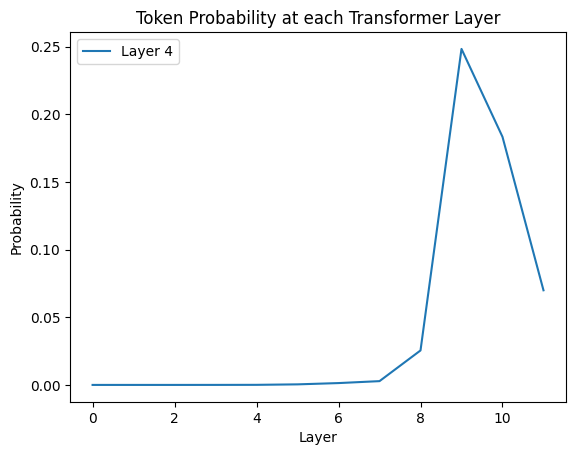

In [37]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(predictions, label=f'Layer {i}')

plt.title('Token Probability at each Transformer Layer')
plt.xlabel('Layer')
plt.ylabel('Probability')

plt.legend()

plt.show()